In [94]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo

def wave(t,*pars):
    amp,t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*amp*(np.exp(-(t-t0)/float(tau1))-np.exp(-(t-t0)/float(tau2)))

def wave(t,*pars):
    amp,t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*amp*(np.exp(-(t-t0)/tau1)-np.exp(-(t-t0)/tau2))

#def linearCombine(a1,b1,a2,b2,a3,b3,c,t0,tau,rise):# (N,*pars):
def linearCombine(a1,b1,a2,b2,c,t0,tau,rise):# (N,*pars):
    N=3500
    t=np.arange(N,dtype=float)
    v=np.zeros((7,N)) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*t)
    v[1,0:N]=b1*np.cos(w*t)
    v[2,0:N]=a2*np.sin(w/2.*t)
    v[3,0:N]=b2*np.cos(w/2.*t)
    v[4,0:N]=c*wave(t,1,t0,tau,rise)
    
#    v[4,0:N]=a3*np.sin(w/4.*t)
#    v[5,0:N]=b3*np.cos(w/4.*t)
#    v[6,0:N]=c*wave(t,1,t0,tau,rise)
    return np.sum(v,axis=0)
means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])

In [97]:
data=fr.raw('/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin',\
            length=3500,row=1000,numwaves=400000)
data=pd.single_pixel(data,1,3)
print len(data)
wo.baseline_restore(data,600)
datacopy=data.copy()
rise,top=20,1
length=len(data['wave'][0])
#DesignT=np.array([linearCombine(1,0,0,0,0,0,0,0,1,1), \
#                   linearCombine(0,1,0,0,0,0,0,0,1,1), \
#                   linearCombine(0,0,1,0,0,0,0,0,1,1), \
#                   linearCombine(0,0,0,1,0,0,0,0,1,1), \
#                   linearCombine(0,0,0,0,1,0,0,0,1,1), \
#                   linearCombine(0,0,0,0,0,1,0,0,1,1), \
#                   linearCombine(0,0,0,0,0,0,0,0,1,1)])
DesignT=np.array([linearCombine(1,0,0,0,0,0,1,1), \
                   linearCombine(0,1,0,0,0,0,1,1), \
                   linearCombine(0,0,1,0,0,0,1,1), \
                   linearCombine(0,0,0,1,0,0,1,1), \
                   linearCombine(0,0,0,0,0,0,1,1)])

t=np.arange(length)
shorttraps=np.zeros((48,length))
wo.multi_trap(arr=shorttraps,rise=20,top=1)
out=np.zeros(length)
#a=np.zeros((len(data),7))
a=np.zeros((len(data),5))
for i in range(len(data)):
    bdch=data['board'][i]*8+data['channel'][i]
    out =fftconvolve(data['wave'][i],shorttraps[bdch],'full')[0:length]/float(rise*means[bdch])
    loc = np.argmax(out)-rise
    mx  = data['wave'][i,loc+10]
#    DesignT[6,0:length]= wave(t,1,loc,means[bdch],7)
    DesignT[4,0:length]= wave(t,1,loc,means[bdch],7)
#    a[i,0:7]=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
#                        DesignT),data['wave'][i])
    a[i,0:5]=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
                        DesignT),data['wave'][i])

#   p=np.zeros(10)
    p=np.zeros(8)
#    p[0:6]=a[i,0:6]
    p[0:4]=a[i,0:4]
#   p[5:8]=loc,means[bdch],7
#    p[6]=0
    p[4]=0
#    p[7:10]=1
    p[5:8]=1
    data['wave'][i,0:length]-=linearCombine(*p).astype('int16')

106773


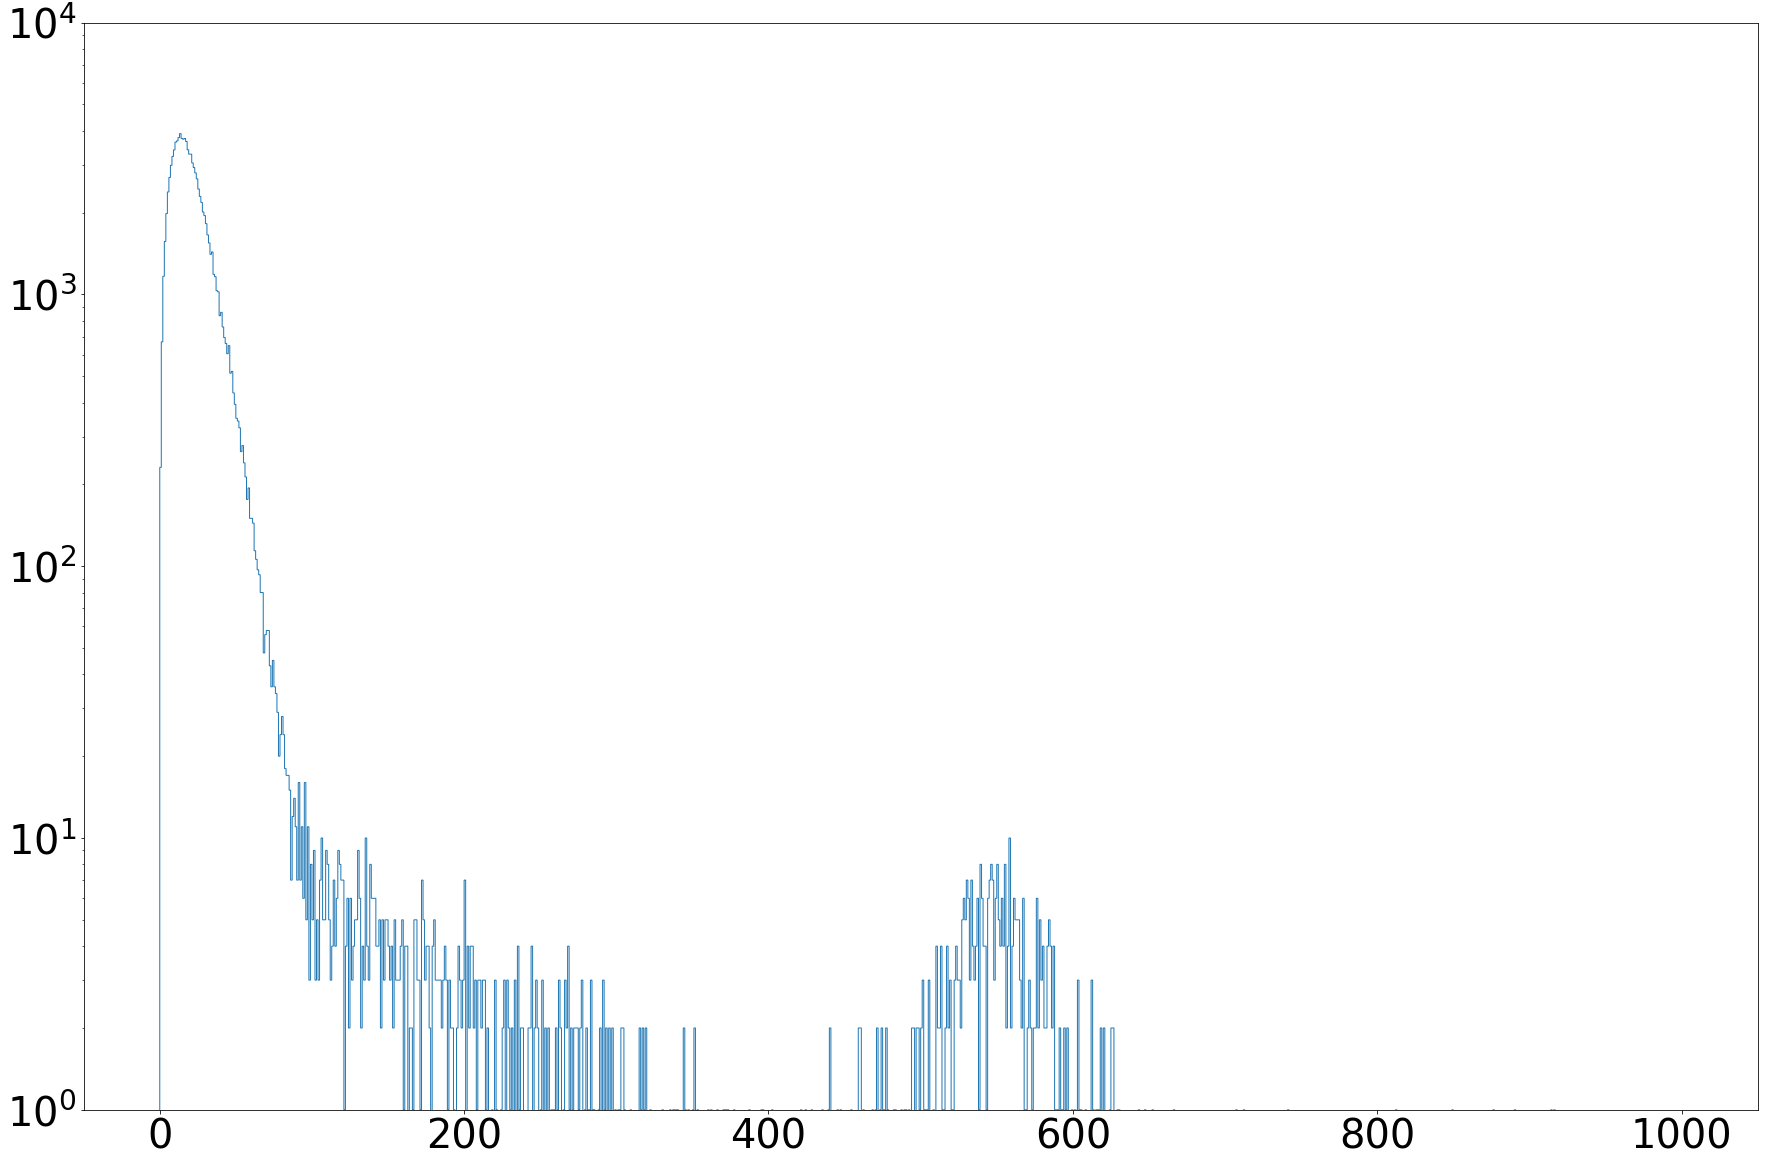

In [98]:
plt.figure(figsize=(30,20))
plt.hist(np.abs(a[:,0])+np.abs(a[:,1]), \
         bins=1000,range=[0,1000],histtype='step')
#plt.plot(t,out)
plt.tick_params(labelsize=40)
plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

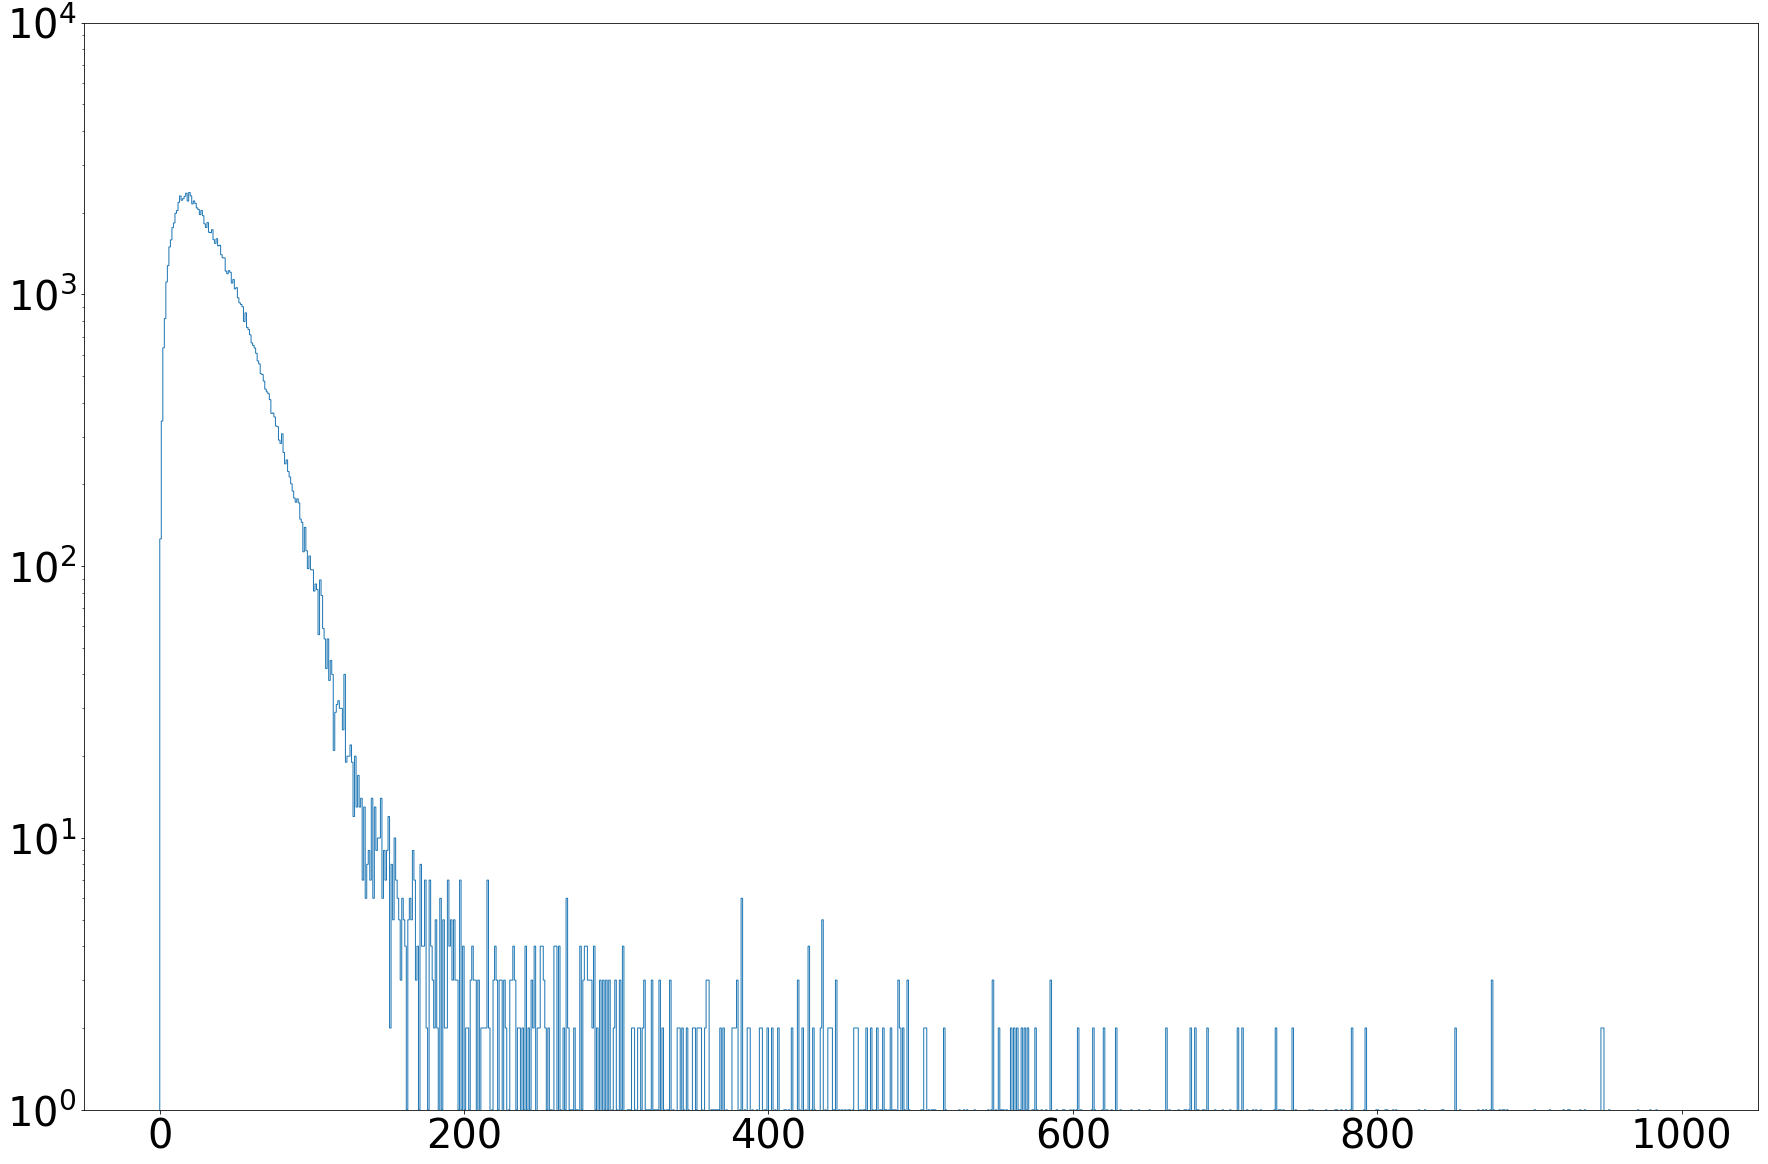

In [99]:
plt.figure(figsize=(30,20))
plt.hist(np.abs(a[:,2])+np.abs(a[:,3]), \
         bins=1000,range=[0,1000],histtype='step')
#plt.plot(t,out)
plt.tick_params(labelsize=40)
plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

plt.figure(figsize=(30,20))
plt.hist(np.abs(a[:,4])+np.abs(a[:,5]), \
         bins=1000,range=[0,1000],histtype='step')
#plt.plot(t,out)
plt.tick_params(labelsize=40)
plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

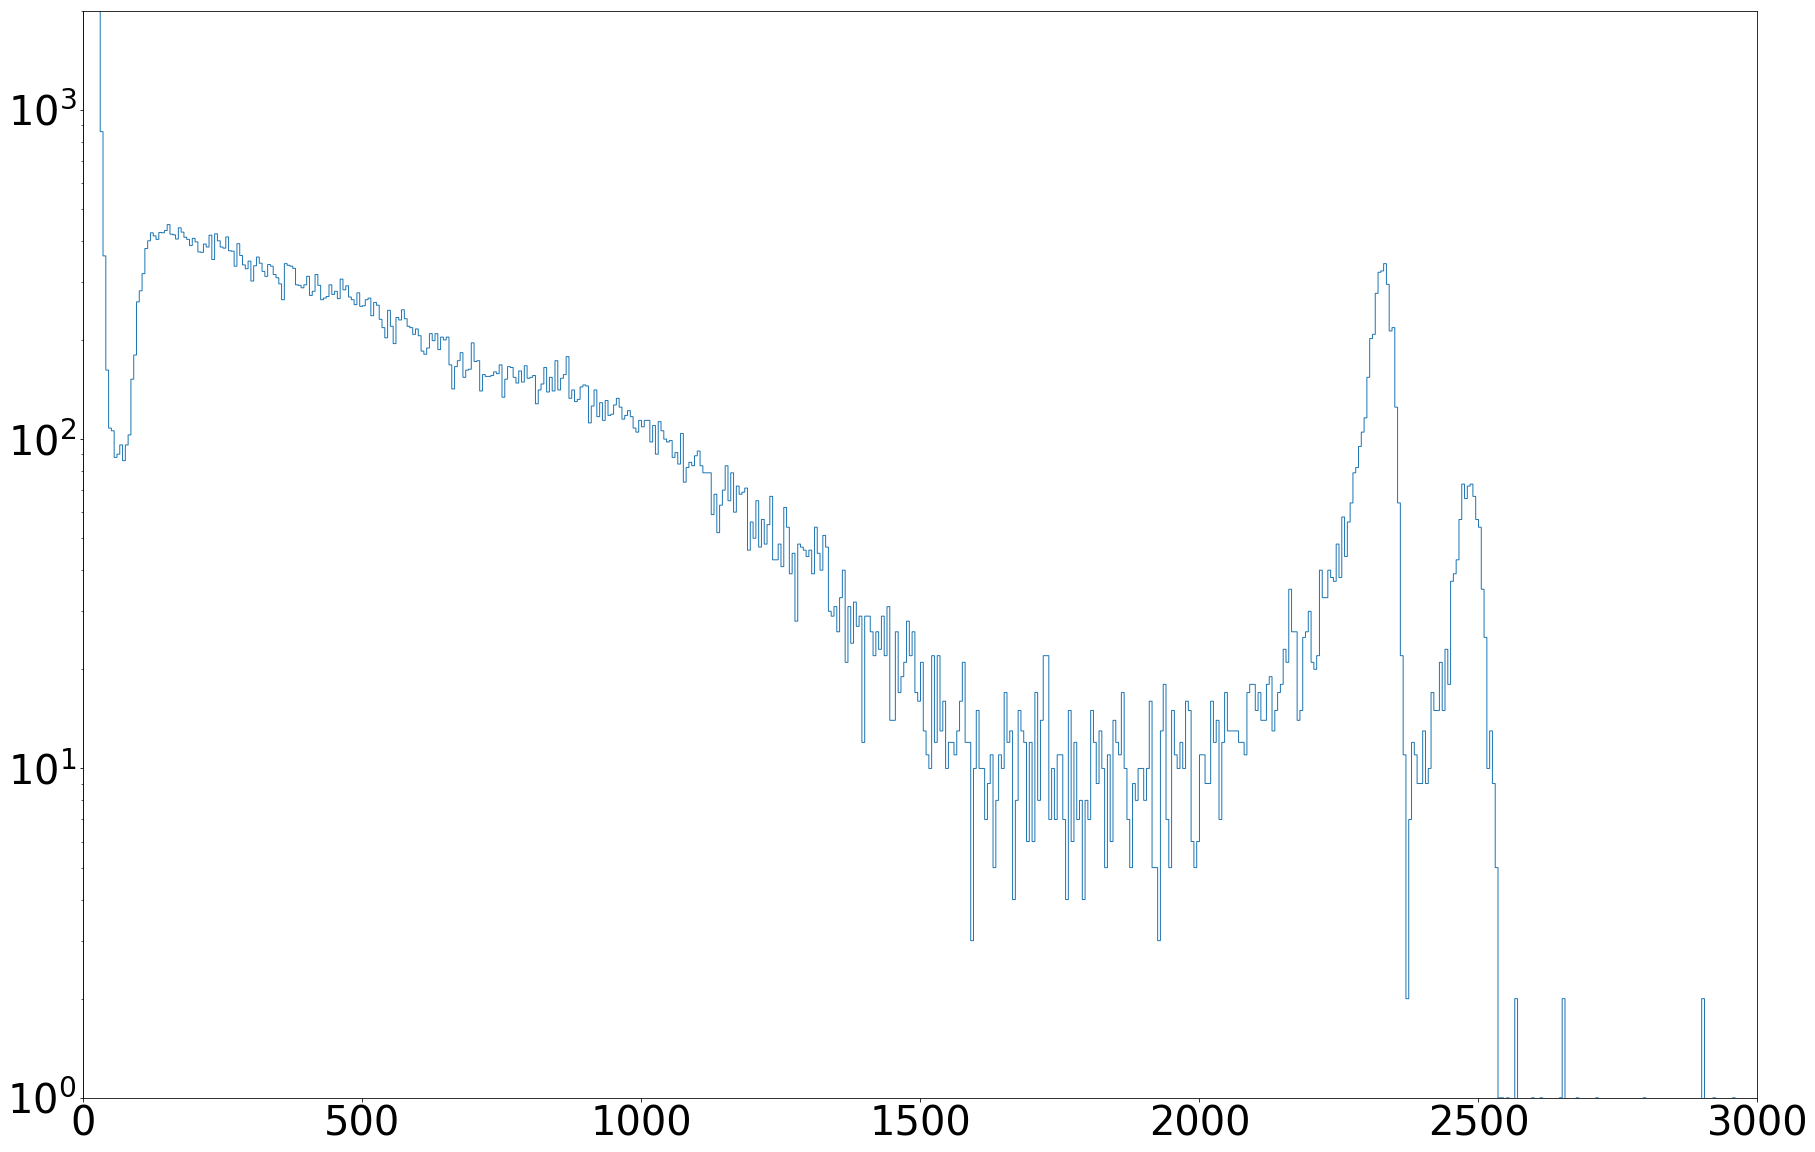

In [101]:
plt.figure(figsize=(30,20))
plt.hist(np.abs(a[:,4]), \
         bins=1000,range=[0,5000],histtype='step')
#plt.plot(t,out)
plt.tick_params(labelsize=40)
plt.yscale('log')
plt.ylim(1,2e3)
plt.xlim(0,3000)
plt.show()